In [1]:
import matplotlib.pyplot as plt
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

In [87]:
df = pd.read_csv("ezprofiler.log", header=0)
df

,Source,Topic,SampleTime,PerfCounter,Elapsed
0,ezmsg.sigproc.synth.SinGenerator,ECOG/OSC/SIN,1.735071e+09,292593.391190,0.0683
1,ezmsg.sigproc.butterworthfilter.ButterworthFilter,ECOG/NOISE/FILTER,1.735071e+09,292593.391738,0.4345
2,ezmsg.sigproc.slicer.Slicer,SELECT,1.735071e+09,292593.392003,0.0175
3,ezmsg.sigproc.butterworthfilter.ButterworthFilter,LP,1.735071e+09,292593.392796,0.6880
4,ezmsg.sigproc.downsample.Downsample,DS,1.735071e+09,292593.392950,0.0320
...,...,...,...,...,...
7995,ezmsg.sigproc.butterworthfilter.ButterworthFilter,LP,1.735071e+09,292613.371510,0.0516
7996,ezmsg.sigproc.downsample.Downsample,DS,1.735071e+09,292613.371622,0.0142
7997,ezmsg.sigproc.affinetransform.CommonRereference,CAR,1.735071e+09,292613.371737,0.0168
7998,ezmsg.sigproc.wavelets.CWT,FREQ,1.735071e+09,292613.376953,5.1242


In [88]:
# Some pre-processing
df["SampleTime"] = df["SampleTime"] - df["SampleTime"].min()
df["PerfCounter"] = df["PerfCounter"] - df["PerfCounter"].min()


# Remove trailing /OUTPUT(_SIGNAL) from Topic
def clean_topic(topic: str) -> str:
    splits = topic.split("/")
    if splits[-1].lower().startswith("out"):
        topic = "/".join(splits[:-1])
    return topic


df["Topic"] = df["Topic"].apply(clean_topic)

print(df["Topic"].unique())
df

['ECOG/OSC/SIN' 'ECOG/NOISE/FILTER' 'SELECT' 'LP' 'DS' 'CAR' 'FREQ'
 'ZSCORE']


,Source,Topic,SampleTime,PerfCounter,Elapsed
0,ezmsg.sigproc.synth.SinGenerator,ECOG/OSC/SIN,0.001500,0.000000,0.0683
1,ezmsg.sigproc.butterworthfilter.ButterworthFilter,ECOG/NOISE/FILTER,0.001431,0.000548,0.4345
2,ezmsg.sigproc.slicer.Slicer,SELECT,0.001500,0.000813,0.0175
3,ezmsg.sigproc.butterworthfilter.ButterworthFilter,LP,0.001500,0.001606,0.6880
4,ezmsg.sigproc.downsample.Downsample,DS,0.000000,0.001760,0.0320
...,...,...,...,...,...
7995,ezmsg.sigproc.butterworthfilter.ButterworthFilter,LP,19.981099,19.980320,0.0516
7996,ezmsg.sigproc.downsample.Downsample,DS,19.979599,19.980432,0.0142
7997,ezmsg.sigproc.affinetransform.CommonRereference,CAR,19.979599,19.980547,0.0168
7998,ezmsg.sigproc.wavelets.CWT,FREQ,19.979599,19.985763,5.1242


In [89]:
df["Topic"].value_counts()

Topic
ECOG/OSC/SIN         1000
ECOG/NOISE/FILTER    1000
SELECT               1000
LP                   1000
DS                   1000
CAR                  1000
FREQ                 1000
ZSCORE               1000
Name: count, dtype: int64

In [90]:
# Provide known order
known_order = [
    "ECOG/OSC/SIN",
    "SELECT",
    "LP",
    "DS",
    "CAR",
    "FREQ",
    "ZSCORE",
]


def plot_topic_times(
    _df: pd.DataFrame,
    x_field: str = "PerfCounter",
    y_field: str = "SampleTime",
    log_y=False,
    x_range=None,
):
    # Plot x=Arrival vs y=Sample, independently for each Topic in known order.
    plt.figure(figsize=(8, 8))
    for topic in known_order:
        sub_df = _df[_df["Topic"] == topic]
        x = sub_df[x_field].values
        y = sub_df[y_field].values
        if x_range is not None:
            import numpy as np

            b_range = np.logical_and(x >= x_range[0], x <= x_range[1])
            x = x[b_range]
            y = y[b_range]
        if log_y:
            plt.semilogy(x, y, label=topic)
        else:
            plt.plot(x, y, label=topic)

    plt.xlabel(x_field)
    plt.ylabel(y_field)
    plt.legend()

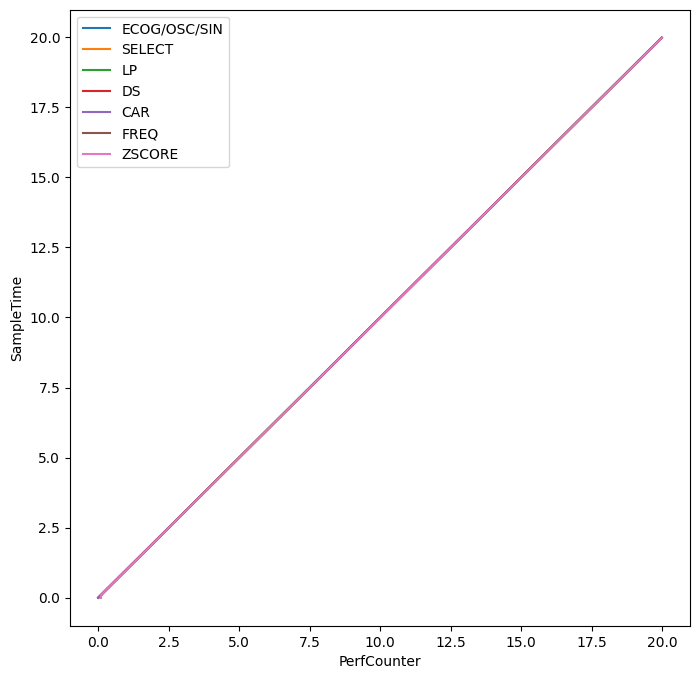

In [91]:
plot_topic_times(df)

In [92]:
from scipy.interpolate import PchipInterpolator

_x = "PerfCounter"  # "Perf" or "Arrival"
# Train pchip or nearest interp func using x=Perf, y=Sample
ref_df = df[df["Topic"] == known_order[0]]
pchip = PchipInterpolator(ref_df[_x].values, ref_df["SampleTime"].values)
# Create new column Delta = interp_func(arrival) - Sample
df["Delta"] = pchip(df[_x].values) - df["SampleTime"].values

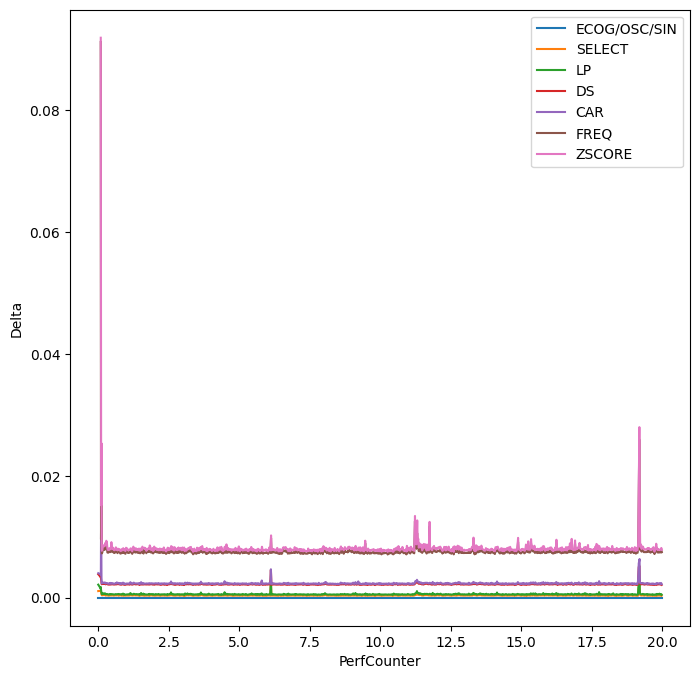

In [93]:
# Plot x=Arrival vs y=Delta, for each Topic
plot_topic_times(df, y_field="Delta", log_y=False)  # , x_range=(16, 17))
# 0 - 0.01: BPFILT -> DOWNSAMPLE -> CAR ---> EWM (0.03 but highly variable)
# plt.ylim([-0.001, 0.02])
# ~0.55: SPECGRAM/WINDOW -> SPECGRAM/SPECTRUM -> SPECGRAM/MODIFYAXIS -> BP/BANDS -> EWM
# plt.ylim([0.54, 0.55])
# 0.605-: DECODE/WINDOW
# plt.ylim([0.6, 0.61])
# ~0.757: DECODE/MODEL -> DECODE/MODIFYAXIS
# plt.ylim([0.74, 0.752])

In [94]:
# Pairwise pchip to get per-node delays
import numpy as np

print("| Topic | Elapsed (ms) | Internode (ms) |")
print("|-------|--------------|----------------|")
for node_ix, ref_node in enumerate(known_order[:-1]):
    ref_df = df[df["Topic"] == ref_node]
    pchip = PchipInterpolator(ref_df[_x].values, ref_df["SampleTime"].values)
    comp_node = known_order[node_ix + 1]
    comp_df = df[df["Topic"] == comp_node]
    node_cost = comp_df["Elapsed"].median()
    delta = pchip(comp_df[_x].values) - comp_df["SampleTime"].values
    print(f"| {comp_node} | {node_cost:.3f} | Total {1000 * np.median(delta):.3f} |")

ref_df = df[df["Topic"] == known_order[0]]
pchip = PchipInterpolator(ref_df[_x].values, ref_df["SampleTime"].values)
comp_df = df[df["Topic"] == known_order[-1]]
cumu = pchip(comp_df[_x].values) - comp_df["SampleTime"].values
print(f"| Cumulative | \t\t | {1000 * np.median(cumu):.3f} |")

| Topic | Elapsed (ms) | Internode (ms) |
|-------|--------------|----------------|
| SELECT | 0.006 | Total 0.366 |
| LP | 0.065 | Total 0.179 |
| DS | 0.016 | Total 1.642 |
| CAR | 0.018 | Total 0.140 |
| FREQ | 5.023 | Total 5.146 |
| ZSCORE | 0.280 | Total 0.439 |
| Cumulative | 		 | 7.931 |


# Throughput Tests

Here are the results from the throughput tests.

| Test | Msg Size (bytes) | Buffers | Msg Rate (Hz) | Mean latency (s) | Data rate (MB/s) |
|------|------------------|---------|---------------|------------------|------------------|
| 1    | 32               | 2       | 11694         | 0.00015          | 0.374            |
| 2    | 32               | 32      | 22325         | 0.00016          | 0.714            |
| 3    | 512              | 2       | 11760         | 0.00014          | 6.021            |
| 4    | 512              | 32      | 21821         | 0.00016          | 11.172           |
| 5    | 8192             | 2       | 11764         | 0.00014          | 96.371           |
| 6    | 8192             | 32      | 21795         | 0.00016          | 178              |
| 7    | 131072           | 2       | 11439         | 0.00014          | 1499             |
| 8    | 131072           | 32      | 20251         | 0.00016          | 2654             |
| 9    | 2097152          | 2       | 6620          | 0.00023          | 13883            |
| 10   | 2097152          | 32      | 6596          | 0.00023          | 13834            |
| 11   | 32               | 2       | 47            | 0.064            | 0.001            |
| 12   | 32               | 32      | 8137          | 0.00063          | 0.260            |
| 13   | 512              | 2       | 47            | 0.0638           | 0.0243           |
| 14   | 512              | 32      | 8295          | 0.00050          | 4.247            |
| 15   | 8192             | 2       | 66            | 0.0456           | 0.543            |
| 16   | 8192             | 32      | 7893          | 0.00057          | 64.661           |
| 17   | 131072           | 2       | 47            | 0.064            | 6.22             |
| 18   | 131072           | 32      | 2441          | 0.0096           | 320              |
| 19   | 2097152          | 2       | 47            | 0.0637           | 98.8             |
| 20   | 2097152          | 32      | 744           | 0.0323           | 1561             |

In [22]:
perf_cols = (
    "Machine",
    "Msg Size (bytes)",
    "buffers",
    "Msg Rate (Hz)",
    "Latency (s)",
    "Data Rate (MB/s)",
)
perf_data = (
    ("M1Pro", 32, 2, 11694, 0.00015, 0.374),
    ("M1Pro", 32, 32, 22325, 0.00016, 0.714),
    ("M1Pro", 512, 2, 11760, 0.00014, 6.021),
    ("M1Pro", 512, 32, 21821, 0.00016, 11.172),
    ("M1Pro", 8192, 2, 11764, 0.00014, 96.371),
    ("M1Pro", 8192, 32, 21795, 0.00016, 178),
    ("M1Pro", 131072, 2, 11439, 0.00014, 1499),
    ("M1Pro", 131072, 32, 20251, 0.00016, 2654),
    ("M1Pro", 2097152, 2, 6620, 0.00023, 13883),
    ("M1Pro", 2097152, 32, 6596, 0.00023, 13834),
    ("RPi5", 32, 2, 47, 0.064, 0.001),
    ("RPi5", 32, 32, 8137, 0.00063, 0.260),
    ("RPi5", 512, 2, 47, 0.0638, 0.0243),
    ("RPi5", 512, 32, 8295, 0.00050, 4.247),
    ("RPi5", 8192, 2, 66, 0.0456, 0.543),
    ("RPi5", 8192, 32, 7893, 0.00057, 64.661),
    ("RPi5", 131072, 2, 47, 0.064, 6.22),
    ("RPi5", 131072, 32, 2441, 0.0096, 320),
    ("RPi5", 2097152, 2, 47, 0.0637, 98.8),
    ("RPi5", 2097152, 32, 744, 0.0323, 1561),
)

perf_df = pd.DataFrame(perf_data, columns=perf_cols)
perf_df

,Machine,Msg Size (bytes),buffers,Msg Rate (Hz),Latency (s),Data Rate (MB/s)
0,M1Pro,32,2,11694,0.00015,0.3740
1,M1Pro,32,32,22325,0.00016,0.7140
2,M1Pro,512,2,11760,0.00014,6.0210
3,M1Pro,512,32,21821,0.00016,11.1720
4,M1Pro,8192,2,11764,0.00014,96.3710
5,M1Pro,8192,32,21795,0.00016,178.0000
6,M1Pro,131072,2,11439,0.00014,1499.0000
7,M1Pro,131072,32,20251,0.00016,2654.0000
8,M1Pro,2097152,2,6620,0.00023,13883.0000
9,M1Pro,2097152,32,6596,0.00023,13834.0000


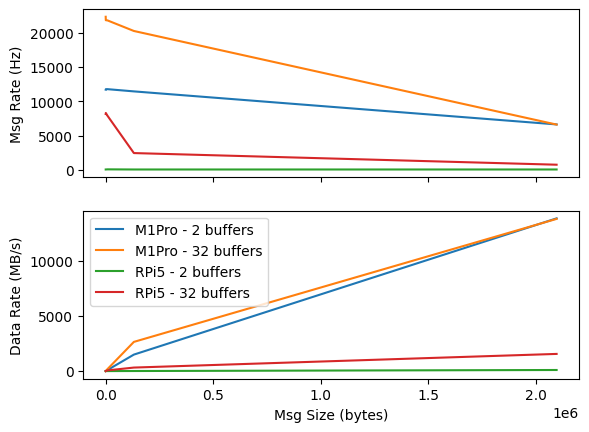

In [26]:
fig, axes = plt.subplots(2, 1, sharex=True)
for mach in perf_df["Machine"].unique():
    for n_buffs in perf_df["buffers"].unique():
        sub_df = perf_df[(perf_df["Machine"] == mach) & (perf_df["buffers"] == n_buffs)]
        axes[0].plot(
            sub_df["Msg Size (bytes)"],
            sub_df["Msg Rate (Hz)"],
            label=f"{mach} - {n_buffs} buffers",
        )
        axes[1].plot(
            sub_df["Msg Size (bytes)"],
            sub_df["Data Rate (MB/s)"],
            label=f"{mach} - {n_buffs} buffers",
        )

axes[1].set_xlabel("Msg Size (bytes)")
axes[0].set_ylabel("Msg Rate (Hz)")
axes[1].set_ylabel("Data Rate (MB/s)")
axes[1].legend()